## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?


In [68]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
import os
import datetime

In [69]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Попробуем для закрепления взять исторические данные с биржи, по стоимости биткоина.

In [190]:
df = pd.read_csv('GBP_RUB.csv')

In [191]:
df.shape

(474, 7)

In [192]:
df.head(3)

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,26.10.2022,"71,009","70,459","71,374","70,287",NaN,"0,76%"
1,25.10.2022,"70,471","69,179","70,735","69,087",NaN,"0,79%"
2,24.10.2022,"69,918","70,022","70,864","68,618",NaN,"0,33%"


In [193]:
df['Цена'] = df['Цена'].apply(lambda x: x[:-2]).apply(lambda x: x[:-1].replace(',', '.'))

In [194]:
df['Откр.'] = df['Откр.'].apply(lambda x: x[:-2]).apply(lambda x: x[:-1].replace(',', '.'))

In [195]:
df['Макс.'] = df['Макс.'].apply(lambda x: x[:-2]).apply(lambda x: x[:-1].replace(',', '.'))

In [196]:
df['Мин.'] = df['Мин.'].apply(lambda x: x[:-2]).apply(lambda x: x[:-1].replace(',', '.'))

In [197]:
df = df.drop('Объём', axis=1)

In [198]:
df['Изм. %'] = df['Изм. %'].apply(lambda x: x[:-1].replace(',', '.'))

In [199]:
df['Дата'] = pd.to_datetime(df['Дата'])
df.index = df['Дата']
df.drop(['Дата'],axis = 1,inplace = True)

C:\Users\user\AppData\Local\Temp\ipykernel_12840\3306576554.py:1: UserWarning: Parsing '26.10.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Дата'] = pd.to_datetime(df['Дата'])
C:\Users\user\AppData\Local\Temp\ipykernel_12840\3306576554.py:1: UserWarning: Parsing '25.10.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Дата'] = pd.to_datetime(df['Дата'])
C:\Users\user\AppData\Local\Temp\ipykernel_12840\3306576554.py:1: UserWarning: Parsing '24.10.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Дата'] = pd.to_datetime(df['Дата'])
C:\Users\user\AppData\Local\Temp\ipykernel_12840\3306576554.py:1: UserWarning: Parsing '21.10.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Дата'] = pd.to_datetime(df['Дата'])
C:\Users\user\AppData\Local\Temp\ipy

In [200]:
df = df.astype(float)

In [201]:
df.sort_index(ascending=True, inplace=True)

In [202]:
df.head(1)

,Цена,Откр.,Макс.,Мин.,Изм. %
Дата,,,,,
2021-01-01,100.0,101.0,101.0,101.0,-0.01


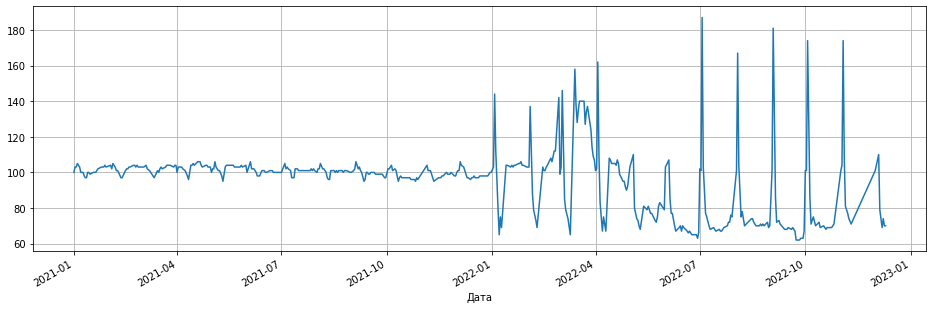

In [203]:
df['Цена'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [204]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df['month'] = pd.to_datetime(df.index).month / 12
df['w_d'] = pd.to_datetime(df.index).dayofyear % 7
df.head()

,Цена,Откр.,Макс.,Мин.,Изм. %,day,month,w_d
Дата,,,,,,,,
2021-01-01,100.0,101.0,101.0,101.0,-0.01,0.002732,0.083333,1
2021-01-02,103.0,103.0,104.0,103.0,0.06,0.005464,0.083333,2
2021-01-03,103.0,103.0,104.0,102.0,0.00,0.008197,0.083333,3
2021-01-04,105.0,104.0,105.0,103.0,1.19,0.010929,0.083333,4
2021-01-06,103.0,104.0,104.0,103.0,-0.19,0.016393,0.083333,6


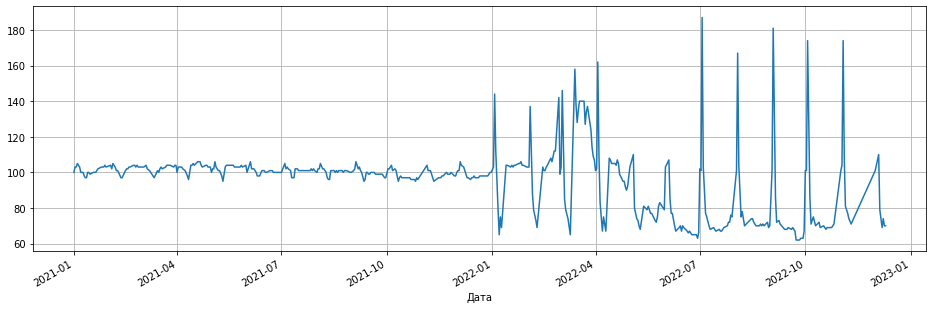

In [205]:
df['Цена'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [206]:
df.head(10)

,Цена,Откр.,Макс.,Мин.,Изм. %,day,month,w_d
Дата,,,,,,,,
2021-01-01,100.0,101.0,101.0,101.0,-0.01,0.002732,0.083333,1
2021-01-02,103.0,103.0,104.0,103.0,0.06,0.005464,0.083333,2
2021-01-03,103.0,103.0,104.0,102.0,0.00,0.008197,0.083333,3
2021-01-04,105.0,104.0,105.0,103.0,1.19,0.010929,0.083333,4
2021-01-06,103.0,104.0,104.0,103.0,-0.19,0.016393,0.083333,6
2021-01-07,100.0,101.0,101.0,100.0,0.00,0.019126,0.083333,0
2021-01-09,100.0,100.0,101.0,100.0,-0.11,0.024590,0.083333,2
2021-01-10,98.0,97.0,99.0,97.0,0.54,0.027322,0.083333,3
2021-01-11,97.0,97.0,97.0,96.0,0.58,0.030055,0.083333,4


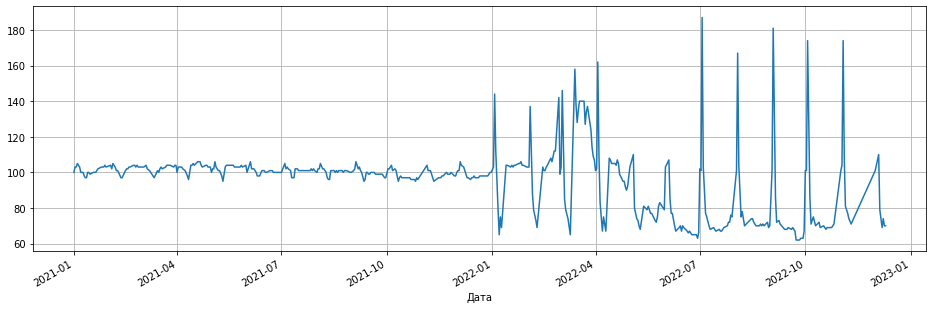

In [207]:
df['Цена'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [208]:
data = df.iloc[7:].copy()

### Важно правильно подготовить датасет для подачи в нейронку

- Разделим датасет по времени, Трейн предыдущие 70% времени, тест остальные 30%

In [217]:
train_split = 350 # Берем точку разделения датасета от начала
channelIndexes = [0,1,2,3,4,5,6,7]   # список признаков, по которым будем учить
# длина истории для работы
xLen = 7
# отступ тестов от тренировок
bias = 5

# вычисляем точку разделения ряда на тесты и тренировку

# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

In [218]:
scaler = StandardScaler()

In [219]:
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
val_data = pd.DataFrame(scaler.transform(val_data), columns=val_data.columns, index=val_data.index)

In [220]:
train_data.head(1)

,Цена,Откр.,Макс.,Мин.,Изм. %,day,month,w_d
Дата,,,,,,,,
2021-01-10,-0.222076,-0.321943,-0.262217,-0.194388,0.230208,-1.422945,-1.377228,-0.119418


- Параметры модели

In [221]:
# шаг по данным для построения обучающих примеров
step = 1
# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h = future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 1000


- Выделяем части на обучение и проверку

In [222]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values # X_valid - Все столбцы 
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее) (y_valid  только целевой столбез будущего )



In [223]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(343, 8)
(343,)
(105, 8)
(105,)


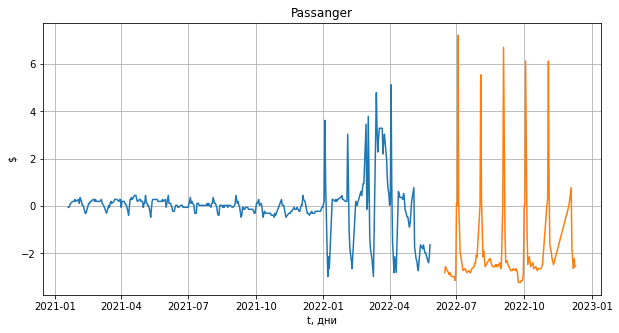

In [224]:
plt.figure(figsize = (10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid()
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Passanger')
plt.show()

- Используем механизм формирования пакетов для обучения

In [225]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)


In [226]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 7, 8)
Target shape: (32,)


- Подключим инструмент наблюдения Tensorboard.

In [227]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Epoch 1/1000
11/11 [==============================] - 4s 93ms/step - loss: 0.9645 - mae: 0.5058 - val_loss: 7.4128 - val_mae: 2.4237
Epoch 2/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.9501 - mae: 0.4970 - val_loss: 7.2188 - val_mae: 2.3867
Epoch 3/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.9410 - mae: 0.4923 - val_loss: 7.0636 - val_mae: 2.3562
Epoch 4/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.9336 - mae: 0.4891 - val_loss: 6.9313 - val_mae: 2.3295
Epoch 5/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.9270 - mae: 0.4863 - val_loss: 6.8116 - val_mae: 2.3048
Epoch 6/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.9207 - mae: 0.4837 - val_loss: 6.6985 - val_mae: 2.2808
Epoch 7/1000
11/11 [==============================] - 0s 26ms/step - loss: 0.9148 - mae: 0.4814 - val_loss: 6.5945 - val_mae: 2.2583
Epoch 8/1000
11/11 [==============================] - 0s 23ms/step - 

11/11 [==============================] - 0s 23ms/step - loss: 0.5611 - mae: 0.3851 - val_loss: 4.2355 - val_mae: 1.5017
Epoch 63/1000
11/11 [==============================] - 0s 24ms/step - loss: 0.5563 - mae: 0.3830 - val_loss: 4.2166 - val_mae: 1.4924
Epoch 64/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.5517 - mae: 0.3809 - val_loss: 4.1986 - val_mae: 1.4836
Epoch 65/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.5473 - mae: 0.3789 - val_loss: 4.1823 - val_mae: 1.4760
Epoch 66/1000
11/11 [==============================] - 0s 24ms/step - loss: 0.5431 - mae: 0.3770 - val_loss: 4.1670 - val_mae: 1.4686
Epoch 67/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.5391 - mae: 0.3751 - val_loss: 4.1536 - val_mae: 1.4624
Epoch 68/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.5352 - mae: 0.3733 - val_loss: 4.1405 - val_mae: 1.4559
Epoch 69/1000
11/11 [==============================] - 0s 22ms/step - loss: 

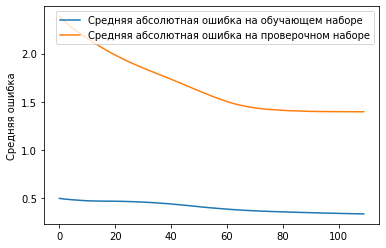

In [229]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(8, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(16))
model.add(Flatten())                          
     
model.add(Dense(512, activation = "relu"))
model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0), metrics = ['mae'])

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [235]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

4/4 [==============================] - 0s 6ms/step


- Визуализация прогноза на тестовых

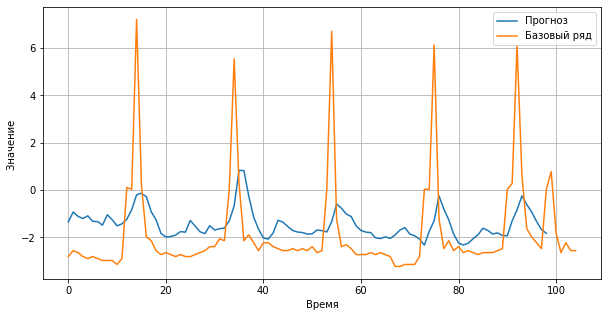

In [236]:
start = 0
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label = 'Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

- Визуализация на трейн данных

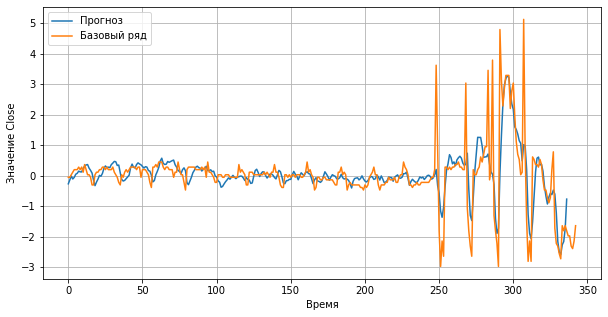

In [237]:
start = 0


plt.figure(figsize = (10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label = 'Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

- Лаговая корреляция

In [238]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()

    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

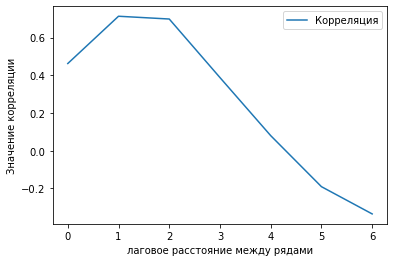

In [239]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 50 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(7):
    corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr,label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

#### С этим датасетом сталкиваюсь с тем, что не могу побороть лаговую корреляцию. Перепробовал кучу вариантов, добавлял слои менял размеры, менял количество признаков, по которым учимся..

In [91]:
fff = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    targets=None,
    sequence_length = xLen,
    sampling_rate = 5,
    
)

In [92]:
model.predict(fff)

1/1 [==============================] - 0s 64ms/step


array([[1.203185 ],
       [1.1170672]], dtype=float32)